In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import matplotlib.ticker as ticker

In [24]:
# Loading Data
source = 'main.csv'
df = pd.read_csv(source, low_memory=False)

In [25]:
# column names normalization
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_").str.replace("(", "").str.replace(")", "")

In [26]:
# datetime conversion
df['service_start_date'] = pd.to_datetime(df['service_start_date'], errors='coerce')
df['service_end_date'] = pd.to_datetime(df['service_end_date'], errors='coerce')
df['revenue_month'] = pd.to_datetime(df['revenue_month'], format='%Y-%m', errors='coerce')


# Extract year and month for easier grouping
df['year'] = df['revenue_month'].dt.year
df['month'] = df['revenue_month'].dt.month
df['season'] = df['month'].apply(lambda x: 'Winter' if x in [12, 1, 2] else
                                'Spring' if x in [3, 4, 5] else
                                'Summer' if x in [6, 7, 8] else 'Fall')


In [27]:
# Data Cleaning, Drop rows with NaN in key columns
df_clean = df.dropna(subset=['revenue_month', 'current_charges', 'consumption_kwh'])

In [39]:
df_clean

,development_name,borough,account_name,location,meter_amr,meter_scope,tds_#,edp,rc_code,funding_source,...,rate_class,bill_analyzed,consumption_kwh,kwh_charges,consumption_kw,kw_charges,other_charges,year,month,season
0,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,GOV/NYC/068,Yes,128800.0,7387.97,216.00,2808.00,5200.85,2010,1,Winter
1,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,GOV/NYC/068,Yes,115200.0,6607.87,224.00,2912.00,5036.47,2010,2,Winter
2,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,GOV/NYC/068,Yes,103200.0,5919.55,216.00,2808.00,5177.43,2010,3,Spring
3,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,GOV/NYC/068,Yes,105600.0,6057.22,208.00,2704.00,6002.82,2010,4,Spring
4,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,GOV/NYC/068,Yes,97600.0,5598.34,216.00,2808.00,5323.20,2010,5,Spring
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521030,WYCKOFF GARDENS,BROOKLYN,WYCKOFF GARDENS,BLD 03,AMR,NaN,163.0,272,K016300,FEDERAL,...,GOV/NYC/068,Yes,78631.0,3967.72,0.00,0.00,5720.22,2024,12,Winter
521031,WYCKOFF GARDENS,BROOKLYN,WYCKOFF GARDENS,BLD 03,AMR,NaN,163.0,272,K016300,FEDERAL,...,GOV/NYC/068,Yes,97796.0,4934.79,0.00,0.00,7114.43,2024,12,Winter
521032,WYCKOFF GARDENS,BROOKLYN,WYCKOFF GARDENS,BLD 02,INTERVAL,NaN,163.0,272,K016300,FEDERAL,...,GOV/NYC/068,Yes,0.0,0.00,121.92,1343.56,1937.00,2024,12,Winter
521033,WYCKOFF GARDENS,BROOKLYN,WYCKOFF GARDENS,BLD 03,INTERVAL,NaN,163.0,272,K016300,FEDERAL,...,GOV/NYC/068,Yes,0.0,0.00,139.20,1533.98,2211.52,2024,12,Winter


In [28]:
# Check total number of records per year
yearly_counts = df_clean.groupby('year').size()
print(yearly_counts)

year
2010    29268
2012    35207
2013    38534
2014    39838
2015    40499
2016    40792
2017    38489
2019    38801
2020    54391
2021    41367
2022    41435
2023    41197
2024    41217
dtype: int64


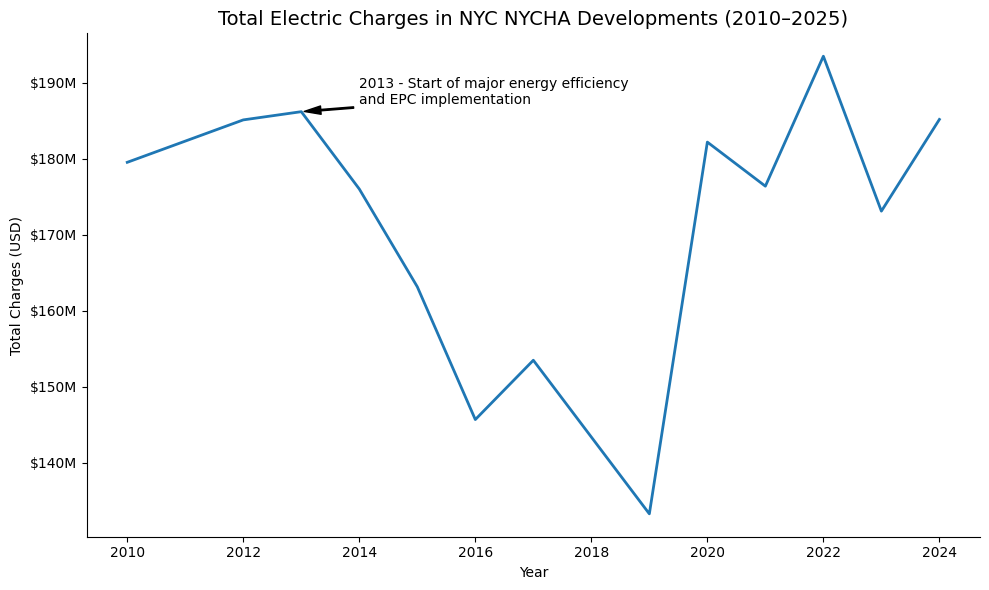

In [106]:
nyc_yearly_costs = df_clean.groupby('year')['current_charges'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(nyc_yearly_costs['year'], nyc_yearly_costs['current_charges'], linewidth=2)
plt.title('Total Electric Charges in NYC NYCHA Developments (2010–2025)', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Total Charges (USD)')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'${x*1e-6:.0f}M'))
plt.tight_layout()

# Locate the row corresponding to the year 2013
row_2013 = nyc_yearly_costs.loc[nyc_yearly_costs['year'] == 2013]

# Extract x and y values for annotation
x = row_2013['year'].values[0]
y = row_2013['current_charges'].values[0]

plt.annotate(
    "2013 - Start of major energy efficiency\nand EPC implementation",
    xy=(x, y),
    xytext=(x + 1, y + 1e6),  # adjust text position
    arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=6),
    fontsize=10,
    ha='left'
)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

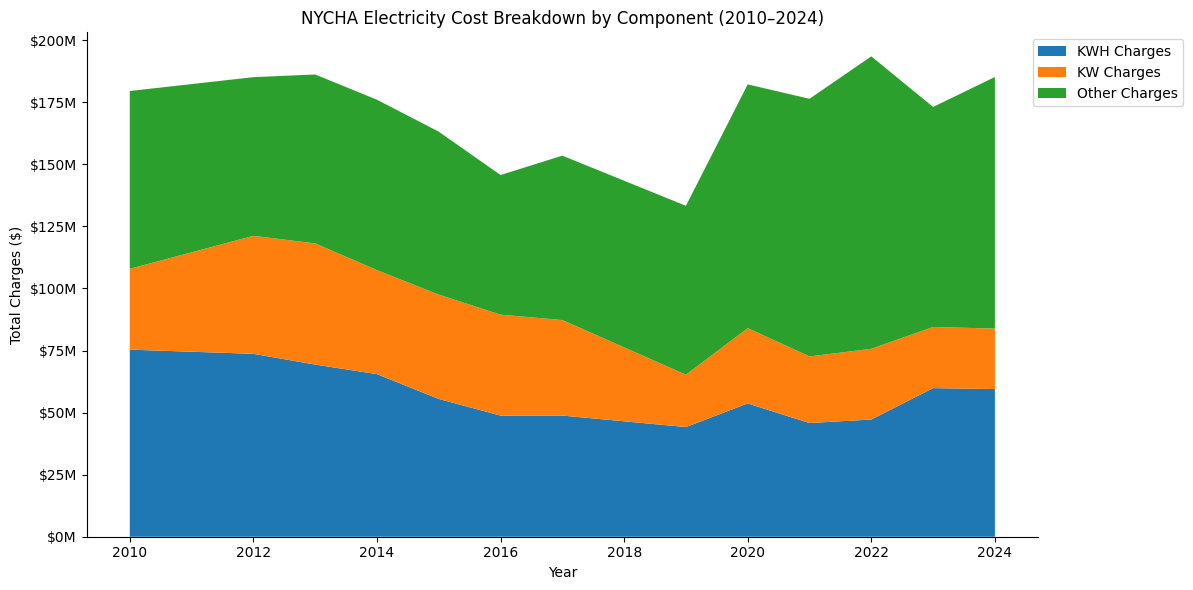

In [78]:
# Aggregate cost components by year
components = df_clean.groupby('year')[['kwh_charges', 'kw_charges', 'other_charges']].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.stackplot(
    components['year'], 
    components['kwh_charges'],  
    components['kw_charges'],  
    components['other_charges'],
    labels=['KWH Charges', 'KW Charges', 'Other Charges']
)

plt.title('NYCHA Electricity Cost Breakdown by Component (2010–2024)')
plt.xlabel('Year')
plt.ylabel('Total Charges ($)')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'${x*1e-6:.0f}M'))
plt.legend(loc='upper right', fontsize=10, bbox_to_anchor=(1.16, 1))
plt.tight_layout()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

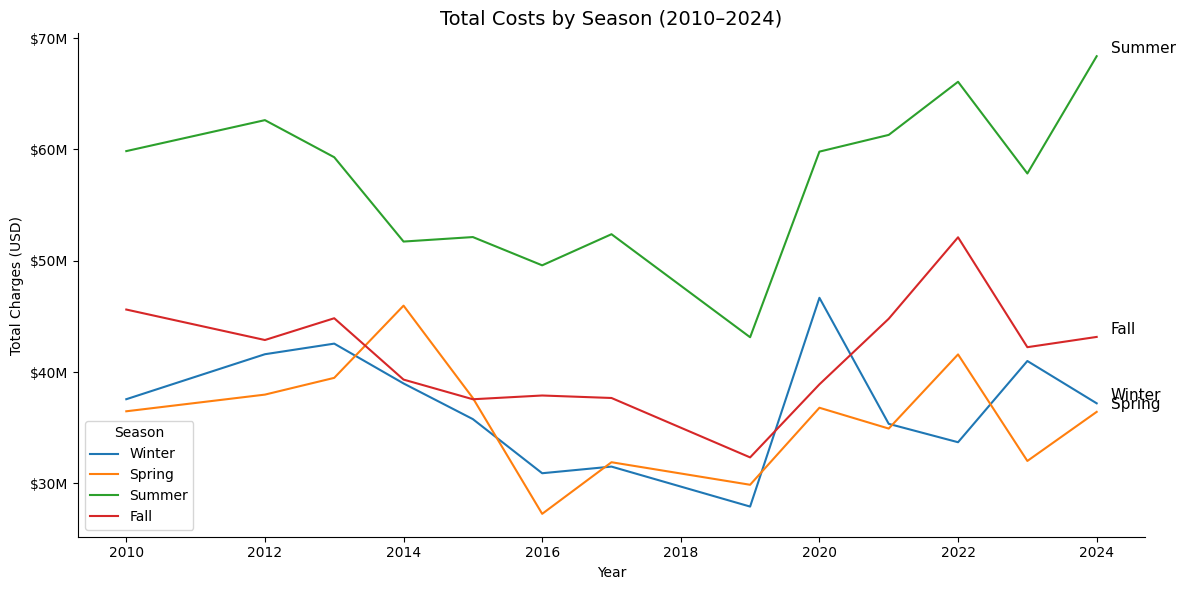

In [87]:
seasonal_avg = df.groupby(['year', 'season']).agg({
    'current_charges': 'sum',
    'consumption_kwh': 'sum'
}).reset_index()
# Pivot table for plotting
pivot_table = seasonal_avg.pivot(index='year', columns='season', values='current_charges').sort_index()

# Plotting the seasonal trends
plt.figure(figsize=(12, 6))
for season in ['Winter', 'Spring', 'Summer', 'Fall']:
    if season in pivot_table.columns:
        plt.plot(pivot_table.index, pivot_table[season], label=season)
        x = pivot_table.index[-1]
        y = pivot_table[season].iloc[-1]
        plt.text(x + 0.2, y - 0.1, season, fontsize=11, va='bottom', ha='left', color='black')

plt.title('Total Costs by Season (2010–2024)', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Total Charges (USD)')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'${x*1e-6:.0f}M'))
plt.legend(title='Season')
plt.tight_layout()

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

In [ ]:
df_clean.to_csv('cleaned_data.csv', index=False)
#v2